# **to train and save the model for the first time**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import os
from sklearn.metrics import classification_report

class MedicalImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform
        self.class_map = {
            'yes': 0, 'no': 1, 'MildDemented': 2,
            'ModerateDemented': 3, 'NonDemented': 4, 'VeryMildDemented': 5,
            'Normal' : 6, 'Doubtful' : 7, 'Mild' : 8, 'Moderate':9, 'Severe': 10
        }

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_folder, image_file)
        im = Image.open(image_path).convert('RGB')
        if self.transform:
            im = self.transform(im)
        folder_name = os.path.basename(self.image_folder)
        label = self.class_map[folder_name]
        return im, label

# Define your transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the data loaders for different classes
image_folders = {
    'yes': "/content/drive/MyDrive/archive.tumor/brain_tumor_dataset/yes",
    'no': "/content/drive/MyDrive/archive.tumor/no",
    'MildDemented': "/content/drive/MyDrive/Alzheimer_Dataset/train/MildDemented",
    'ModerateDemented': "/content/drive/MyDrive/Alzheimer_Dataset/train/ModerateDemented",
    'NonDemented': "/content/drive/MyDrive/Alzheimer_Dataset/train/NonDemented",
    'VeryMildDemented': "/content/drive/MyDrive/Alzheimer_Dataset/train/VeryMildDemented",
    'Normal' : '/content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Normal',
    'Doubtful':'/content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Doubtful',
    'Moderate':'/content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Moderate',
    'Severe' : '/content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Severe'
}

# Verify that each folder contains images and is read correctly
for label, folder in image_folders.items():
    if not os.path.exists(folder):
        print(f"Folder not found: {folder}")
    else:
        files = os.listdir(folder)
        if not files:
            print(f"No images found in folder: {folder}")
        else:
            print(f"Found {len(files)} images in folder: {folder}")

datasets = []
for label, folder in image_folders.items():
    datasets.append(MedicalImageDataset(folder, transform))

combined_dataset = ConcatDataset(datasets)
batch_size = 32
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define and train your model as before
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 10, kernel_size=5)  # 3 channels for RGB images
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(20 * 53 * 53, 50)
        self.fc2 = torch.nn.Linear(50, 11)  # Changed to 11 classes

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 20 * 53 * 53)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = CNNModel().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):  # train for 10 epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

# Save the trained model
torch.save(model.state_dict(), 'cnn_model.pth')
print("Model saved as 'cnn.model.pth'")

# Evaluate the model (optional but recommended for first run)
model.eval()
test_loss = 0
correct = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = correct / len(val_loader.dataset)
print(f'Test Loss: {test_loss / len(val_loader)}')
print(f'Test Accuracy: {accuracy:.2f}%')


# Print classification report
from sklearn.metrics import classification_report
unique_classes = sorted(set(all_labels))
class_names = ['Brain Tumor Detected', 'No Brain Tumor', 'Mild Dementia Detected', 'Moderate Dementia Detected', 'No Dementia Detected', 'Very Mild Dementia Detected',
               'Normal Arthiritis','Doubtful Arthiritis','Mild Arthiritis','Moderate Arthiritis','Severe Arthiritis']
print(classification_report(all_labels, all_predictions, target_names=[class_names[i] for i in unique_classes]))


# Define detailed_info for diagnosis details
detailed_info = [
    {'diagnosis': 'Brain Tumor Detected',
        'causes': 'Genetic mutations, radiation exposure, family history, certain chemicals and industrial products, immune system disorders',
        'prevention': 'Avoiding radiation exposure, protective gear in industrial settings, genetic counseling if family history is known',
        'diet': 'High fiber foods, fruits, vegetables, lean proteins, avoiding processed foods and sugars',
        'exercise': 'Moderate aerobic exercise, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'No Brain Tumor',
        'causes': 'N/A',
        'prevention': 'Regular health check-ups, maintaining a healthy lifestyle',
        'diet': 'Balanced diet rich in fruits, vegetables, whole grains, and lean proteins',
        'exercise': 'Regular physical activity, a mix of aerobic, strength, and flexibility exercises'
    },
    {
        'diagnosis': 'Mild Dementia Detected',
        'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
        'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
        'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
        'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'
    },
    {
        'diagnosis': 'Moderate Dementia Detected',
        'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
        'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
        'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
        'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'
    },
    {
        'diagnosis': 'No Dementia Detected',
        'causes': 'N/A',
        'prevention': 'Healthy lifestyle, regular cognitive and physical activities',
        'diet': 'Balanced diet rich in fruits, vegetables, whole grains, and lean proteins',
        'exercise': 'Regular physical activity, a mix of aerobic, strength, and flexibility exercises'
    },
    {
        'diagnosis': 'Very Mild Dementia Detected',
        'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
        'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
        'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
        'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'
    },
    {
        'diagnosis': 'Normal Arthritis Detected',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'Arthritis is Doubtful',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'Mild Arthritis Detected',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'Moderate Arthritis Detected',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'Severe Arthritis Detected',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    }

]

def diagnose(image_path):
    im = Image.open(image_path).convert('RGB')
    im = transform(im).unsqueeze(0)
    im = im.to(device)
    with torch.no_grad():
        output = model(im)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def print_diagnosis_details(diagnosis_index):
    diagnosis_details = detailed_info[diagnosis_index]
    print(f"Diagnosis: {diagnosis_details['diagnosis']}")
    print(f"Causes: {diagnosis_details['causes']}")
    print(f"Prevention: {diagnosis_details['prevention']}")
    print(f"Diet: {diagnosis_details['diet']}")
    print(f"Exercise: {diagnosis_details['exercise']}")

# Test the diagnosis function
image_path = "/content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Moderate/ModerateG3_54.png"
diagnosis_index = diagnose(image_path)
diagnosis_statement = class_names[diagnosis_index]

# Print the detailed diagnosis result
img = Image.open(image_path)
img.show()
print()
print(f'Result : {diagnosis_statement}')
print_diagnosis_details(diagnosis_index)





Found 85 images in folder: /content/drive/MyDrive/archive.tumor/brain_tumor_dataset/yes
Found 100 images in folder: /content/drive/MyDrive/archive.tumor/no
Found 717 images in folder: /content/drive/MyDrive/Alzheimer_Dataset/train/MildDemented
Found 52 images in folder: /content/drive/MyDrive/Alzheimer_Dataset/train/ModerateDemented
Found 2580 images in folder: /content/drive/MyDrive/Alzheimer_Dataset/train/NonDemented
Found 1792 images in folder: /content/drive/MyDrive/Alzheimer_Dataset/train/VeryMildDemented
Found 514 images in folder: /content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Normal
Found 477 images in folder: /content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Doubtful
Found 222 images in folder: /content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Moderate
Found 207 images in folder: /content/drive/MyDrive/MedicalExpert-I/MedicalExpert-I/Severe
Epoch 1, Loss: 1.1037194579839706
Epoch 2, Loss: 0.7163460926995391
Epoch 3, Loss: 0.4913598449812049
Epoch 4, Loss: 0.3

# once the model is trained, there is no longer need of retraining the model again and again. Just load the model in the below snippet.

Result
----------



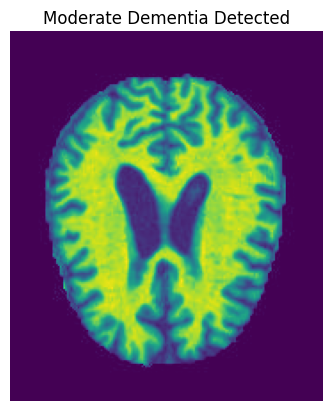


Diagnosis: Moderate Dementia Detected
Causes: Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)
Prevention: Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors
Diet: Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins
Exercise: Aerobic exercises, strength training, balance and flexibility exercises


In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define class names
class_names = [
    'Brain Tumor Detected', 'No Brain Tumor', 'Mild Dementia Detected',
    'Moderate Dementia Detected', 'No Dementia Detected', 'Very Mild Dementia Detected',
    'Normal Arthiritis', 'Doubtful Arthiritis', 'Mild Arthiritis',
    'Moderate Arthiritis', 'Severe Arthiritis'
]

# Define detailed information for diagnosis
detailed_info = [
    {'diagnosis': 'Brain Tumor Detected',
        'causes': 'Genetic mutations, radiation exposure, family history, certain chemicals and industrial products, immune system disorders',
        'prevention': 'Avoiding radiation exposure, protective gear in industrial settings, genetic counseling if family history is known',
        'diet': 'High fiber foods, fruits, vegetables, lean proteins, avoiding processed foods and sugars',
        'exercise': 'Moderate aerobic exercise, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'No Brain Tumor',

    },
    {
        'diagnosis': 'Mild Dementia Detected',
        'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
        'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
        'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
        'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'
    },
    {
        'diagnosis': 'Moderate Dementia Detected',
        'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
        'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
        'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
        'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'
    },
    {
        'diagnosis': 'No Dementia Detected',

    },
    {
        'diagnosis': 'Very Mild Dementia Detected',
        'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
        'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
        'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
        'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'
    },
    {
        'diagnosis': 'Normal Arthritis Detected',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'Arthritis is Doubtful',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'Mild Arthritis Detected',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'Moderate Arthritis Detected',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    },
    {
        'diagnosis': 'Severe Arthritis Detected',
        'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
        'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
        'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
        'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'
    }
]

class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 10, kernel_size=5)  # 3 channels for RGB images
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(20 * 53 * 53, 50)
        self.fc2 = torch.nn.Linear(50, 11)  # Changed to 11 classes

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 20 * 53 * 53)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = CNNModel()
model_path = "/content/cnn_model.pth"

if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)
model.eval()

# Define the transform for inference
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def diagnose(image_path):
    im = Image.open(image_path).convert('RGB')
    im = transform(im).unsqueeze(0)
    im = im.to(device)
    with torch.no_grad():
        output = model(im)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def print_diagnosis_details(diagnosis_index):
    diagnosis_details = detailed_info[diagnosis_index]
    print(f"Diagnosis: {diagnosis_details['diagnosis']}")
    print(f"Causes: {diagnosis_details['causes']}")
    print(f"Prevention: {diagnosis_details['prevention']}")
    print(f"Diet: {diagnosis_details['diet']}")
    print(f"Exercise: {diagnosis_details['exercise']}")

# Test the diagnosis function
image_path = "/content/27.jpg"
diagnosis_index = diagnose(image_path)
diagnosis_statement = class_names[diagnosis_index]

# Print the detailed diagnosis result
img = Image.open(image_path)
print(f'Result')
print("----------\n")
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title(diagnosis_statement)  # Add title with diagnosis statement
plt.show()
print()

print_diagnosis_details(diagnosis_index)




In [ ]:
!pip install flask-ngrok


In [ ]:
!wget https://bin.equinox.io/c/4b1b6q1d4ux/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-07-23 18:36:01--  https://bin.equinox.io/c/4b1b6q1d4ux/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-07-23 18:36:02 ERROR 404: Not Found.

unzip:  cannot find or open ngrok-stable-linux-amd64.zip, ngrok-stable-linux-amd64.zip.zip or ngrok-stable-linux-amd64.zip.ZIP.


In [ ]:
!./ngrok http 5000


/bin/bash: line 1: ./ngrok: No such file or directory


In [ ]:
from flask import Flask, request, render_template, redirect, url_for, flash
import os
from werkzeug.utils import secure_filename
import torch
from torchvision import transforms
from PIL import Image

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = '/content/uploads'
app.config['ALLOWED_EXTENSIONS'] = {'png', 'jpg', 'jpeg'}
app.secret_key = 'supersecretkey'

app.template_folder = '/content/drive/MyDrive/MyFlask/templates'

if not os.path.exists(app.config['UPLOAD_FOLDER']):
    os.makedirs(app.config['UPLOAD_FOLDER'])

class_names = [ 'Brain Tumor Detected', 'No Brain Tumor', 'Mild Dementia Detected',
    'Moderate Dementia Detected', 'No Dementia Detected', 'Very Mild Dementia Detected',
    'Normal Arthritis', 'Doubtful Arthritis', 'Mild Arthritis',
    'Moderate Arthritis', 'Severe Arthritis' ]  # Define your class names here
detailed_info = [ {'diagnosis': 'Brain Tumor Detected',
     'causes': 'Genetic mutations, radiation exposure, family history, certain chemicals and industrial products, immune system disorders',
     'prevention': 'Avoiding radiation exposure, protective gear in industrial settings, genetic counseling if family history is known',
     'diet': 'High fiber foods, fruits, vegetables, lean proteins, avoiding processed foods and sugars',
     'exercise': 'Moderate aerobic exercise, strength training, flexibility exercises'},
    {'diagnosis': 'No Brain Tumor',
     'causes': '',
     'prevention': '',
     'diet': '',
     'exercise': ''},
    {'diagnosis': 'Mild Dementia Detected',
     'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
     'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
     'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
     'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'},
    {'diagnosis': 'Moderate Dementia Detected',
     'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
     'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
     'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
     'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'},
    {'diagnosis': 'No Dementia Detected',
     'causes': '',
     'prevention': '',
     'diet': '',
     'exercise': ''},
    {'diagnosis': 'Very Mild Dementia Detected',
     'causes': 'Age, family history, genetics, head trauma, lifestyle factors (smoking, alcohol use)',
     'prevention': 'Healthy diet, regular exercise, cognitive activities, managing cardiovascular risk factors',
     'diet': 'Mediterranean diet, foods rich in omega-3 fatty acids, antioxidants, and vitamins',
     'exercise': 'Aerobic exercises, strength training, balance and flexibility exercises'},
    {'diagnosis': 'Normal Arthritis Detected',
     'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
     'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
     'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
     'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'},
    {'diagnosis': 'Arthritis is Doubtful',
     'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
     'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
     'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
     'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'},
    {'diagnosis': 'Mild Arthritis Detected',
     'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
     'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
     'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
     'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'},
    {'diagnosis': 'Moderate Arthritis Detected',
     'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
     'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
     'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
     'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'},
    {'diagnosis': 'Severe Arthritis Detected',
     'causes': 'Age, joint injury, obesity, genetics, overuse of the joint',
     'prevention': 'Maintaining healthy weight, regular exercise, protecting joints from injury',
     'diet': 'Anti-inflammatory diet, rich in omega-3 fatty acids, fruits, vegetables, whole grains',
     'exercise': 'Low-impact aerobic exercises, strength training, flexibility exercises'} ]  # Define detailed info here

# Define CNN model
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(20 * 53 * 53, 50)
        self.fc2 = torch.nn.Linear(50, 11)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 20 * 53 * 53)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel()
model_path = "/content/drive/MyDrive/MyFlask/cnn_model.pth"

if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

def get_className(classNo):
    return class_names[classNo]

def getResult(img_path):
    im = Image.open(img_path).convert('RGB')
    im = transform(im).unsqueeze(0)
    im = im.to(device)
    with torch.no_grad():
        output = model(im)
        _, predicted = torch.max(output, 1)
    return predicted.item()

def get_detailed_info(classNo):
    return detailed_info[classNo]

@app.route('/', methods=['GET'])
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def upload():
    if 'file' not in request.files:
        flash('No file part')
        return redirect(request.url)

    file = request.files['file']

    if file.filename == '':
        flash('No selected file')
        return redirect(request.url)

    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(filepath)

        result_index = getResult(filepath)
        result = get_className(result_index)
        detailed_result = get_detailed_info(result_index)

        return render_template('result.html', result=result, detailed_result=detailed_result)

    flash('Allowed file types are png, jpg, jpeg')
    return redirect(request.url)

if __name__ == '__main__':
    app.run(port=5000,debug=True)  # Run on port 5000


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
!pip install flask
!pip install flask-ngrok



In [ ]:
!wget https://bin.equinox.io/c/4b1b6q1d4ux/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-07-23 18:43:22--  https://bin.equinox.io/c/4b1b6q1d4ux/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-07-23 18:43:23 ERROR 404: Not Found.

unzip:  cannot find or open ngrok-stable-linux-amd64.zip, ngrok-stable-linux-amd64.zip.zip or ngrok-stable-linux-amd64.zip.ZIP.
